<a href="https://colab.research.google.com/github/arya31/Classification-of-Cervical-Cancer-Tissue-using-Ensemble-Stacking/blob/main/CRC_VAL_HE_7K_JPG_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/CRC-VAL-HE-7K_JPG.zip

In [ ]:
!wget https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py

--2022-06-19 14:39:20--  https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21413 (21K) [text/plain]
Saving to: ‘Helper.py’

Helper.py           100%[===================>]  20.91K  --.-KB/s    in 0.001s  

2022-06-19 14:39:21 (20.0 MB/s) - ‘Helper.py’ saved [21413/21413]



In [ ]:
import json
import os
import Helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from termcolor import cprint
from PIL import Image
from glob import glob
import time

In [ ]:
def create_dataframe(source_folder_path):
  label_dict = {}
  for index, class_name in enumerate(os.listdir(source_folder_path)):
    label_dict[class_name] = float(index)
  image_paths, labels = [], []
  for class_name in os.listdir(source_folder_path):
    subfolder_path = os.path.join(source_folder_path, class_name)
    for img_path in os.listdir(subfolder_path):
      image_paths.append(os.path.join(subfolder_path, img_path))
      labels.append(label_dict[class_name])
  dataframe = pd.DataFrame(
      {
          'source': image_paths,
          'label': labels
      }
  )
  dataframe.to_csv('metadata.csv', index = False)
  with open('class_names.json', 'w') as out_file:
    json.dump(label_dict, out_file)
    out_file.close()
source_folder_path = '/content/CRC-VAL-HE-7K_JPG/CRC-VAL-HE-7K'
create_dataframe(source_folder_path)

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models

In [ ]:
class ColoData(Dataset):
  def __init__(self,meta_df_path, H = 224, W = 224):
    super(ColoData, self).__init__()
    self.meta_df = pd.read_csv(meta_df_path)
    self.H = H
    self.W = W

  def load_image(self, source):
    img = Image.open(source)
    img = img.resize((self.H, self.W),Image.ANTIALIAS)
    return img

  def __len__(self):
    return len(self.meta_df)

  def __numC__(self):
    return self.meta_df['label'].nunique()
  
  def __getitem__(self, index):
    source = self.meta_df.iloc[index]['source']
    label = self.meta_df.iloc[index]['label']
    image = self.load_image(source)
    image = transforms.ToTensor()(image)
    return (image, label)

In [ ]:
dataset = ColoData('/content/metadata.csv')

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_data_size = int(0.80 *dataset.__len__())
val_data_size = dataset.__len__() - train_data_size
train_ds, val_ds = torch.utils.data.random_split(dataset,[train_data_size, val_data_size] )
test_data_size = 1000
train_ds, test_ds = torch.utils.data.random_split(train_ds,[train_data_size - 1000, test_data_size] )
print(train_ds.__len__())
print(val_ds.__len__())
print(test_ds.__len__())

4744
1436
1000


In [ ]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)
for (patch, labels) in train_dl:
  print(patch.shape, labels.shape)
  break
for (patch, labels) in val_dl:
  print(patch.shape, labels.shape)
  break
for (patch, labels) in test_dl:
  print(patch.shape, labels.shape)
  break

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.Size([128, 3, 224, 224]) torch.Size([128])


In [ ]:
device = 'cuda'

In [ ]:
class Model1(nn.Module): # Resnet18
  
  def __init__(self, num_classes):
    super(Model1, self).__init__()

    self.resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    self.op_layer = nn.Linear(1000, num_classes)

  def forward(self, x):
    op1 = self.resnet18(x)
    output = self.op_layer(op1)
    return output
model = Model1(9).to(device)
summary(model, (3,224,224), batch_size = 1, device = device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           9,408
       BatchNorm2d-2          [1, 64, 112, 112]             128
              ReLU-3          [1, 64, 112, 112]               0
         MaxPool2d-4            [1, 64, 56, 56]               0
            Conv2d-5            [1, 64, 56, 56]          36,864
       BatchNorm2d-6            [1, 64, 56, 56]             128
              ReLU-7            [1, 64, 56, 56]               0
            Conv2d-8            [1, 64, 56, 56]          36,864
       BatchNorm2d-9            [1, 64, 56, 56]             128
             ReLU-10            [1, 64, 56, 56]               0
       BasicBlock-11            [1, 64, 56, 56]               0
           Conv2d-12            [1, 64, 56, 56]          36,864
      BatchNorm2d-13            [1, 64, 56, 56]             128
             ReLU-14            [1, 64,

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def accuracy(true, pred):
  true = true.cpu().detach().numpy()
  pred = pred.cpu().detach().numpy()

  pred = np.argmax(pred, axis = 1)
  acc = sum([abs(pred[i] == true[i]) for i in range(len(true))])

  return acc

In [ ]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
# Model Training...
train_loss = []
val_loss = []
test_loss = []
best_loss = np.inf
for epoch in range(EPOCHS):
  epoch_start = time.time()
  print(f"Epoch {epoch + 1} : ")
  TR_LOSS = 0.0
  VAL_LOSS = 0.0
  TEST_LOSS = 0.0
  model.train()
  
  # Train Data Forward & Backward Pass
  train_acc = 0
  for index, (train_patch, labels) in enumerate(train_dl):
      optim.zero_grad()
      train_patch = train_patch.float().cuda()
      labels = labels.long().cuda()
      op = model(train_patch)
      acc = accuracy(labels, op)
      train_acc += acc
      tloss = criterion(op, labels)
      TR_LOSS += tloss.item()
      train_loss.append(tloss.item())
      tloss.backward()
      optim.step()
      
      if index % 100 == 99:
          print(f"         Step {index + 1} -> Loss : {'%.4f'%(tloss.item())}")
  model.eval()
  
  # Validation Checking ( Only Forward Pass )
  val_acc = 0
  test_acc = 0
  with torch.no_grad():
      for index, (val_patch, labels) in enumerate(val_dl):
          val_patch = val_patch.float().cuda()
          labels = labels.long().cuda()
          op = model(val_patch)
          acc = accuracy(labels, op)
          val_acc += acc
          vloss = criterion(op, labels)
          VAL_LOSS += vloss.item()
          val_loss.append(vloss.item())
      for index, (test_patch, labels) in enumerate(test_dl):
          test_patch = test_patch.float().cuda()
          labels = labels.long().cuda()
          op = model(test_patch)
          acc = accuracy(labels, op)
          test_acc += acc
          tsloss = criterion(op, labels)
          TEST_LOSS += tsloss.item()
          test_loss.append(tsloss.item())
  print(f"\n     Training Loss : {'%.4f'%(TR_LOSS)}  ||  Validation Loss : {'%.4f'%(VAL_LOSS)} ||  Test Loss : {'%.4f'%(TEST_LOSS)}")
  print(f"     Training Accuracy : {'%.6f'%(train_acc * 100 / train_ds.__len__())} %  ||  Validation Accuracy : {'%.6f'%(val_acc * 100 / val_ds.__len__())} %  ||  Testing Accuracy : {'%.6f'%(test_acc * 100 /test_ds.__len__())} % \n")
  
  if VAL_LOSS < best_loss :      # Model Updationg
      cprint("Model Updation : Success!", 'green')
      torch.save(model, 'best_model.pth')
      best_loss = VAL_LOSS
  else:
      cprint("Model Updation : Failed!", 'red')
  epoch_end = time.time()
  print(f"Elapsed Time : {int(epoch_end - epoch_start) // 60}m {int(epoch_end - epoch_start) % 60}s \n")
cprint('Training completed...', 'blue')

Epoch 1 : 

     Training Loss : 29.4557  ||  Validation Loss : 47.7993 ||  Test Loss : 31.6411
     Training Accuracy : 75.042159 %  ||  Validation Accuracy : 41.782730 %  ||  Testing Accuracy : 43.000000 % 

Model Updation : Success!
Elapsed Time : 0m 25s 

Epoch 2 : 

     Training Loss : 10.8813  ||  Validation Loss : 14.7564 ||  Test Loss : 10.4723
     Training Accuracy : 90.619730 %  ||  Validation Accuracy : 62.186630 %  ||  Testing Accuracy : 62.600000 % 

Model Updation : Success!
Elapsed Time : 0m 31s 

Epoch 3 : 

     Training Loss : 9.5298  ||  Validation Loss : 47.9698 ||  Test Loss : 33.9839
     Training Accuracy : 92.137437 %  ||  Validation Accuracy : 37.952646 %  ||  Testing Accuracy : 38.800000 % 

Model Updation : Failed!
Elapsed Time : 0m 24s 

Epoch 4 : 

     Training Loss : 7.2626  ||  Validation Loss : 5.7019 ||  Test Loss : 3.6736
     Training Accuracy : 93.423272 %  ||  Validation Accuracy : 78.272981 %  ||  Testing Accuracy : 79.600000 % 

Model Updation 

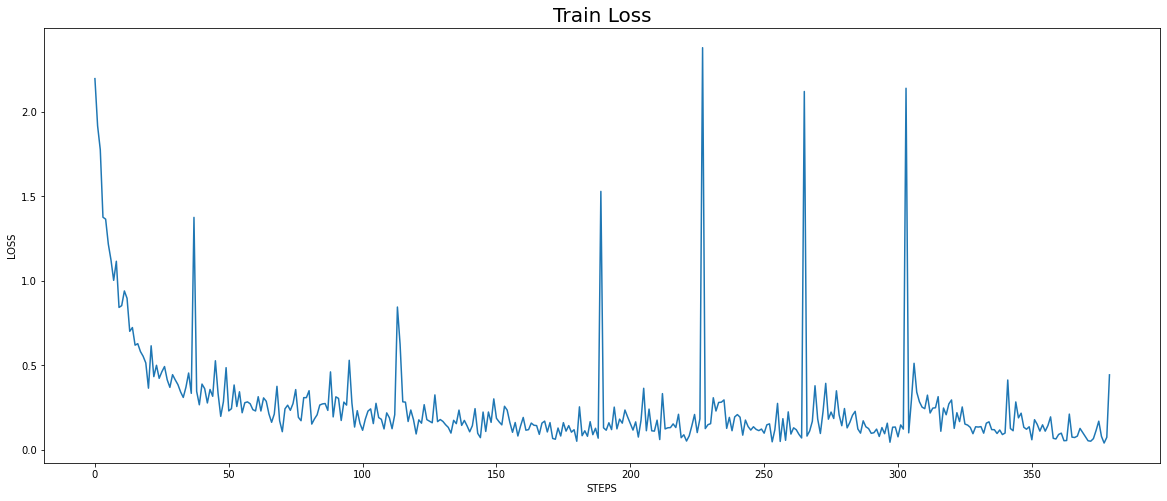

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_loss)
plt.title('Train Loss', size = 20)
plt.xlabel('STEPS')
plt.ylabel('LOSS')
plt.show()

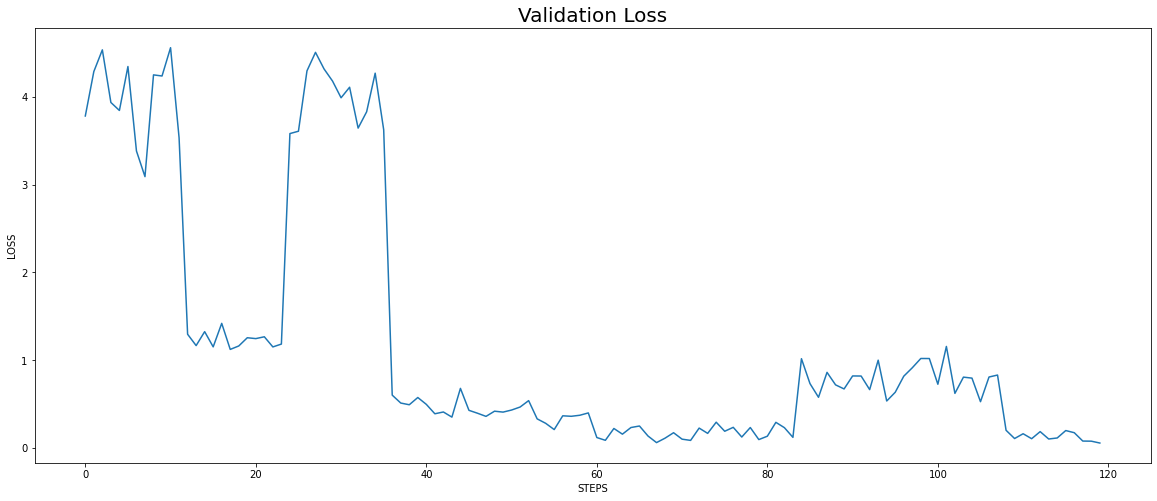

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(val_loss)
plt.title('Validation Loss', size = 20)
plt.xlabel('STEPS')
plt.ylabel('LOSS')
plt.show()

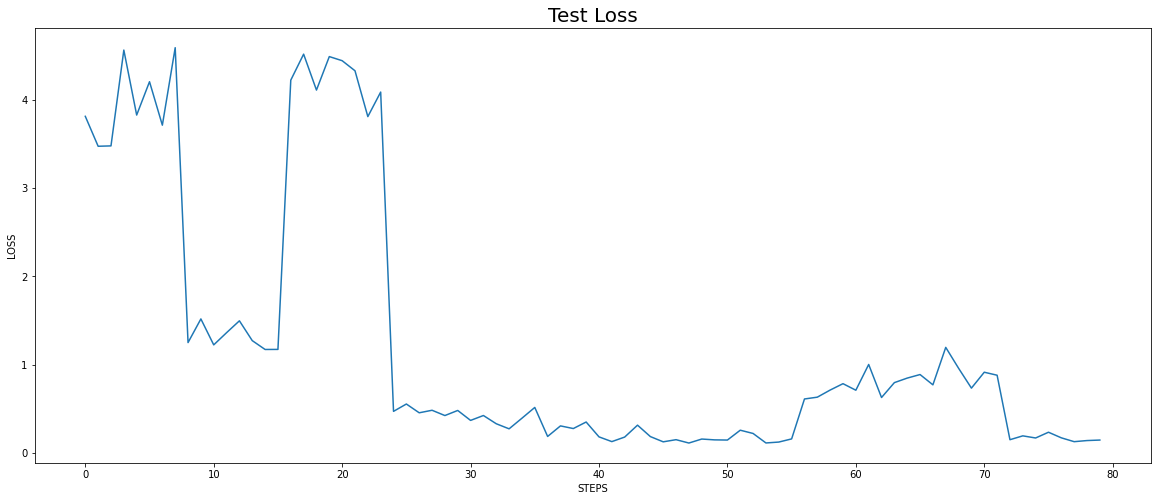

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(test_loss)
plt.title('Test Loss', size = 20)
plt.xlabel('STEPS')
plt.ylabel('LOSS')
plt.show()

In [ ]:
!nvidia-smi

Sun Jun 19 15:02:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |   5748MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class Model2(nn.Module): # EfficientNetB0
  
  def __init__(self, num_classes):
    super(Model2, self).__init__()

    self.densenet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
    self.op_layer = nn.Linear(1000, num_classes)

  def forward(self, x):
    op1 = self.densenet(x)
    output = self.op_layer(op1)
    return output
model = Model2(9).to(device)
summary(model, (3,224,224), batch_size = 1, device = device)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 112, 112]             864
       BatchNorm2d-2          [1, 32, 112, 112]              64
              SiLU-3          [1, 32, 112, 112]               0
            Conv2d-4          [1, 32, 112, 112]             288
       BatchNorm2d-5          [1, 32, 112, 112]              64
              SiLU-6          [1, 32, 112, 112]               0
            Linear-7                     [1, 8]             264
              SiLU-8                     [1, 8]               0
            Linear-9                    [1, 32]             288
          Sigmoid-10                    [1, 32]               0
SequentialSqueezeAndExcitation-11          [1, 32, 112, 112]               0
           Conv2d-12          [1, 16, 112, 112]             512
      BatchNorm2d-13          [1, 16, 112, 112]              32
      MBConvBlock-14      

In [ ]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
train_loss = []
val_loss = []
test_loss = []
best_loss = np.inf
for epoch in range(EPOCHS):
  epoch_start = time.time()
  print(f"Epoch {epoch + 1} : ")
  TR_LOSS = 0.0
  VAL_LOSS = 0.0
  TEST_LOSS = 0.0
  model.train()
  
  # Train Data Forward & Backward Pass
  train_acc = 0
  for index, (train_patch, labels) in enumerate(train_dl):
      optim.zero_grad()
      train_patch = train_patch.float().cuda()
      labels = labels.long().cuda()
      op = model(train_patch)
      acc = accuracy(labels, op)
      train_acc += acc
      tloss = criterion(op, labels)
      TR_LOSS += tloss.item()
      train_loss.append(tloss.item())
      tloss.backward()
      optim.step()
      
      if index % 100 == 99:
          print(f"         Step {index + 1} -> Loss : {'%.4f'%(tloss.item())}")
  model.eval()
  
  # Validation Checking ( Only Forward Pass )
  val_acc = 0
  test_acc = 0
  with torch.no_grad():
      for index, (val_patch, labels) in enumerate(val_dl):
          val_patch = val_patch.float().cuda()
          labels = labels.long().cuda()
          op = model(val_patch)
          acc = accuracy(labels, op)
          val_acc += acc
          vloss = criterion(op, labels)
          VAL_LOSS += vloss.item()
          val_loss.append(vloss.item())
      for index, (test_patch, labels) in enumerate(test_dl):
          test_patch = test_patch.float().cuda()
          labels = labels.long().cuda()
          op = model(test_patch)
          acc = accuracy(labels, op)
          test_acc += acc
          tsloss = criterion(op, labels)
          TEST_LOSS += tsloss.item()
          test_loss.append(tsloss.item())
  print(f"\n     Training Loss : {'%.4f'%(TR_LOSS)}  ||  Validation Loss : {'%.4f'%(VAL_LOSS)} ||  Test Loss : {'%.4f'%(TEST_LOSS)}")
  print(f"     Training Accuracy : {'%.6f'%(train_acc * 100 / train_ds.__len__())} %  ||  Validation Accuracy : {'%.6f'%(val_acc * 100 / val_ds.__len__())} %  ||  Testing Accuracy : {'%.6f'%(test_acc * 100 /test_ds.__len__())} % \n")
  
  if VAL_LOSS < best_loss :      # Model Updationg
      cprint("Model Updation : Success!", 'green')
      torch.save(model, 'best_model.pth')
      best_loss = VAL_LOSS
  else:
      cprint("Model Updation : Failed!", 'red')
  epoch_end = time.time()
  print(f"Elapsed Time : {int(epoch_end - epoch_start) // 60}m {int(epoch_end - epoch_start) % 60}s \n")
cprint('Training completed...', 'blue')

Epoch 1 : 

     Training Loss : 26.7170  ||  Validation Loss : 14.0495 ||  Test Loss : 9.4424
     Training Accuracy : 80.269815 %  ||  Validation Accuracy : 63.857939 %  ||  Testing Accuracy : 64.400000 % 

Model Updation : Success!
Elapsed Time : 0m 44s 

Epoch 2 : 

     Training Loss : 2.5958  ||  Validation Loss : 8.2613 ||  Test Loss : 5.7513
     Training Accuracy : 98.693086 %  ||  Validation Accuracy : 81.406685 %  ||  Testing Accuracy : 81.000000 % 

Model Updation : Success!
Elapsed Time : 0m 44s 

Epoch 3 : 

     Training Loss : 0.8444  ||  Validation Loss : 4.5765 ||  Test Loss : 3.0830
     Training Accuracy : 99.641653 %  ||  Validation Accuracy : 91.573816 %  ||  Testing Accuracy : 91.600000 % 

Model Updation : Success!
Elapsed Time : 0m 44s 

Epoch 4 : 

     Training Loss : 1.3927  ||  Validation Loss : 2.8399 ||  Test Loss : 1.9174
     Training Accuracy : 99.894604 %  ||  Validation Accuracy : 93.941504 %  ||  Testing Accuracy : 94.700000 % 

Model Updation : Suc

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=9):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        self.modelA.fc = nn.Identity()
        self.modelB.fc = nn.Identity()
        
        # Create new classifier
        self.classifier = nn.Linear(2048+512, nb_classes)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

model = MyEnsemble(Model1, Model2, 9)

In [ ]:
train_loss = []
val_loss = []
test_loss = []
best_loss = np.inf
for epoch in range(EPOCHS):
  epoch_start = time.time()
  print(f"Epoch {epoch + 1} : ")
  TR_LOSS = 0.0
  VAL_LOSS = 0.0
  TEST_LOSS = 0.0
  model.train()
  
  # Train Data Forward & Backward Pass
  train_acc = 0
  for index, (train_patch, labels) in enumerate(train_dl):
      optim.zero_grad()
      train_patch = train_patch.float().cuda()
      labels = labels.long().cuda()
      op = model(train_patch)
      acc = accuracy(labels, op)
      train_acc += acc
      tloss = criterion(op, labels)
      TR_LOSS += tloss.item()
      train_loss.append(tloss.item())
      tloss.backward()
      optim.step()
      
      if index % 100 == 99:
          print(f"         Step {index + 1} -> Loss : {'%.4f'%(tloss.item())}")
  model.eval()
  
  # Validation Checking ( Only Forward Pass )
  val_acc = 0
  test_acc = 0
  with torch.no_grad():
      for index, (val_patch, labels) in enumerate(val_dl):
          val_patch = val_patch.float().cuda()
          labels = labels.long().cuda()
          op = model(val_patch)
          acc = accuracy(labels, op)
          val_acc += acc
          vloss = criterion(op, labels)
          VAL_LOSS += vloss.item()
          val_loss.append(vloss.item())
      for index, (test_patch, labels) in enumerate(test_dl):
          test_patch = test_patch.float().cuda()
          labels = labels.long().cuda()
          op = model(test_patch)
          acc = accuracy(labels, op)
          test_acc += acc
          tsloss = criterion(op, labels)
          TEST_LOSS += tsloss.item()
          test_loss.append(tsloss.item())
  print(f"\n     Training Loss : {'%.4f'%(TR_LOSS)}  ||  Validation Loss : {'%.4f'%(VAL_LOSS)} ||  Test Loss : {'%.4f'%(TEST_LOSS)}")
  print(f"     Training Accuracy : {'%.6f'%(train_acc * 100 / train_ds.__len__())} %  ||  Validation Accuracy : {'%.6f'%(val_acc * 100 / val_ds.__len__())} %  ||  Testing Accuracy : {'%.6f'%(test_acc * 100 /test_ds.__len__())} % \n")
  
  if VAL_LOSS < best_loss :      # Model Updationg
      cprint("Model Updation : Success!", 'green')
      torch.save(model, 'best_model.pth')
      best_loss = VAL_LOSS
  else:
      cprint("Model Updation : Failed!", 'red')
  epoch_end = time.time()
  print(f"Elapsed Time : {int(epoch_end - epoch_start) // 60}m {int(epoch_end - epoch_start) % 60}s \n")
cprint('Training completed...', 'blue')

Epoch 1 : 


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


TypeError: ignored

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix

In [ ]:
def create_conf_mat(loader, model):
  y_true = []
  y_pred = []

  with torch.no_grad():
          for index, (patch, labels) in enumerate(loader):
            patch = patch.float().cuda()
            labels = labels.long().cuda()
            op = model(patch)
            labels = labels.cpu().detach().numpy()
            op = op.cpu().detach().numpy()
            op = np.argmax(op, axis = 1)
            for el in op:
              y_pred.append(el)
            for el in labels:
              y_true.append(el)
  mat=confusion_matrix(y_true,y_pred)
  plot_confusion_matrix(mat,figsize=(9,9),colorbar=True)
  plt.show()

  return mat

In [ ]:
def pr_and_rc(mat):
  tp = [mat[i][i] for i in range(len(mat))]
  pr_arr = np.sum(mat,axis = 0)
  rc_arr = np.sum(mat,axis = 1)

  precision = sum([tp[i]/pr_arr[i] for i in range(len(mat))]) / len(mat)
  recall = sum([tp[i]/rc_arr[i] for i in range(len(mat))]) / len(mat)

  print(f'Precision : {precision} || Recall : {recall}')
  print(f"F1-Score : {2 * (precision*recall) / (precision + recall)}")

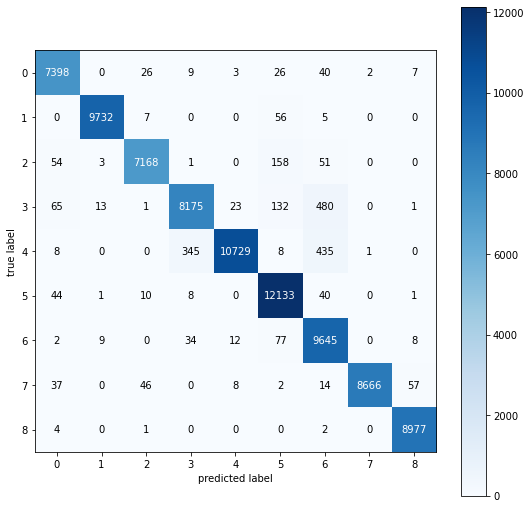

Precision : 0.9735023941529796 || Recall : 0.9722410961944663
F1-Score : 0.9728713363653295


In [ ]:
train_conf = create_conf_mat(train_dl, best_model)
pr_and_rc(train_conf)

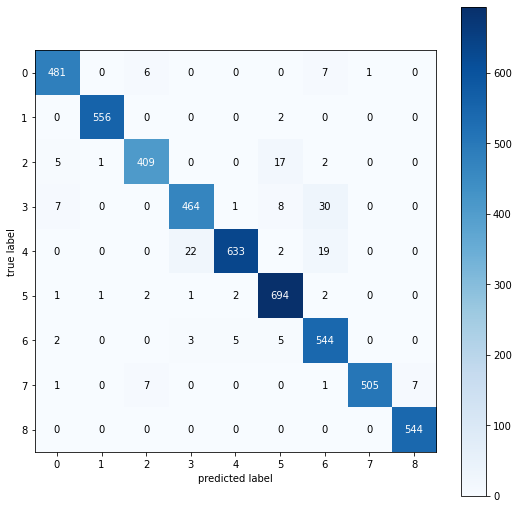

Precision : 0.9667881475174804 || Recall : 0.9651530699570962
F1-Score : 0.9659699168221811


In [ ]:
val_conf = create_conf_mat(val_dl, best_model)
pr_and_rc(val_conf)

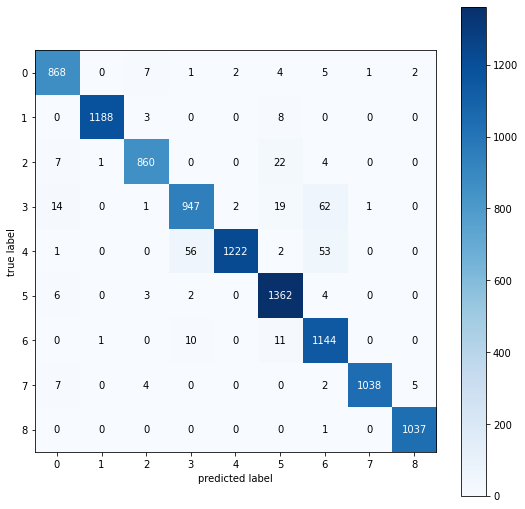

Precision : 0.967810091898766 || Recall : 0.9668556620157044
F1-Score : 0.9673326415324855


In [ ]:
test_conf = create_conf_mat(test_dl, best_model)
pr_and_rc(test_conf)